<a href="https://colab.research.google.com/github/agrudkow/Cost-Free-Incremental-Learning/blob/main/notebooks/base_implementation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cost Free Incremental Learning

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)  ## False
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_classes=cif.N_CLASSES_PER_TASK*cif.N_TASKS
model.fc = nn.Linear(512, num_classes)

In [ ]:
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size=32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Set PYTHONPATH\
import os
import pathlib
os.environ['PYTHONPATH']+=os.environ['PYTHONPATH']+":"+"/content/Cost-Free-Incremental-Learning"

NameError: ignored

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from argparse import ArgumentParser
from utils.args import add_management_args
parser = ArgumentParser(description='cflr', allow_abbrev=False)

add_management_args(parser)
args = parser.parse_known_args()[0]


In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from backbone.ResNet18 import resnet18
import torch.nn.functional as F
from datasets.seq_tinyimagenet import base_path
from PIL import Image
from datasets.utils.validation import get_train_val
from datasets.utils.continual_dataset import ContinualDataset, store_masked_loaders
from datasets.utils.continual_dataset import get_previous_train_loader
from typing import Tuple
from datasets.transforms.denormalization import DeNormalize


class SequentialCIFAR10(ContinualDataset):

    NAME = 'seq-cifar10'
    SETTING = 'class-il'
    N_CLASSES_PER_TASK = 2
    N_TASKS = 5
    TRANSFORM = transforms.Compose(
            [transforms.RandomCrop(32, padding=4),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2470, 0.2435, 0.2615))])

    def get_data_loaders(self):
        transform = self.TRANSFORM

        test_transform = transforms.Compose(
            [transforms.ToTensor(), self.get_normalization_transform()])

        train_dataset = MyCIFAR10(base_path() + 'CIFAR10', train=True,
                                  download=True, transform=transform)
        if self.args.validation:
            train_dataset, test_dataset = get_train_val(train_dataset,
                                                    test_transform, self.NAME)
        else:
            test_dataset = CIFAR10(base_path() + 'CIFAR10',train=False,
                                   download=True, transform=test_transform)

        train, test = store_masked_loaders(train_dataset, test_dataset, self)
        return train, test

    def not_aug_dataloader(self, batch_size):
        transform = transforms.Compose([transforms.ToTensor(), self.get_normalization_transform()])

        train_dataset = MyCIFAR10(base_path() + 'CIFAR10', train=True,
                                  download=True, transform=transform)
        train_loader = get_previous_train_loader(train_dataset, batch_size, self)

        return train_loader

    @staticmethod
    def get_transform():
        transform = transforms.Compose(
            [transforms.ToPILImage(), SequentialCIFAR10.TRANSFORM])
        return transform

    @staticmethod
    def get_backbone():
        return resnet18(SequentialCIFAR10.N_CLASSES_PER_TASK
                        * SequentialCIFAR10.N_TASKS)

    @staticmethod
    def get_loss():
        return F.cross_entropy

    @staticmethod
    def get_normalization_transform():
        transform = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2470, 0.2435, 0.2615))
        return transform

    @staticmethod
    def get_denormalization_transform():
        transform = DeNormalize((0.4914, 0.4822, 0.4465),
                                (0.2470, 0.2435, 0.2615))
        return transform


class MyCIFAR10(CIFAR10):
    """
    Overrides the CIFAR10 dataset to change the getitem function.
    """
    def __init__(self, root, train=True, transform=None,
                 target_transform=None, download=False) -> None:
        self.not_aug_transform = transforms.Compose([transforms.ToTensor()])
        super(MyCIFAR10, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index: int) -> Tuple[Image.Image, int, Image.Image]:
        """
        Gets the requested element from the dataset.
        :param index: index of the element to be returned
        :returns: tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # to return a PIL Image
        img = Image.fromarray(img, mode='RGB')
        original_img = img.copy()

        not_aug_img = self.not_aug_transform(original_img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if hasattr(self, 'logits'):
            return img, target, not_aug_img, self.logits[index]

        return img, target, not_aug_img



In [ ]:
setattr(args, "validation", True)
setattr(args, "batch_size", 32)

In [ ]:
def generateDirch(batch_size,c,scale, simMat):   ##### copied
	x=[]
	print("sim", simMat.shape)
	sim=simMat[c,:] 
	for b in range(batch_size):
		#temp=sim*scale
		temp=(sim-np.min(sim))/(np.max(sim)-np.min(sim))
		temp=temp*scale + 0.0001
		x.append(np.random.dirichlet(temp))
	x=np.array(x)

	return x


In [ ]:
import pickle
import sklearn.preprocessing as pp
import numpy as np

torch.set_default_dtype(torch.float64)

def recovery_memory(model, dataset, n_tasks):
   fc_weights = model.fc.weight.detach().numpy()

   #fc_bias=model.fc.bias
   fc_weights=np.transpose(fc_weights)  ####### nasz pomysł
   print(fc_weights.shape)
   fc_weight_norm =  pp.normalize(fc_weights,axis=0)
   im_sim_mat = np.matmul(np.transpose(fc_weight_norm),fc_weight_norm)

   norm1=(im_sim_mat-np.min(im_sim_mat))/(np.max(im_sim_mat)-np.min(im_sim_mat))


   

   #img_tensor=img_tensor.to(torch.double)

   #img_tensor=torch.tensor(inputs[0].reshape((1,3, 32,32)), requires_grad=True)

   images_all=[]
   logits_all=[]

   for classes in range(n_tasks*2):
    p =1 ### ile obrazków generujemy
    pseudolabel = generateDirch(p,classes,1,norm1)  ### scale =0.1 ?


    
    for i in range(p):
      img=np.random.normal(0.5, 0.5, size=(32,32,3))
      #img=img.reshape(3, 32,32)
      img=img.astype(np.float32)

      print(inputs[0].dtype)
      img_tensor=torch.tensor(img.reshape((1,3, 32,32)), requires_grad=True)
      plt.imshow(transforms.ToPILImage()(img_tensor.reshape(3,32,32)))
      plt.show()


      logits=model(img_tensor)
      print(logits)
      loss=criterion(logits, torch.tensor(pseudolabel[i]).reshape(1,-1))
      loss.backward()
    
    ########## add assert on weights

      img_tensor_grad=img_tensor+img_tensor.grad
      

      logits_synthetic=model(img_tensor_grad).detach().numpy() #### brakuje pętli aby generować więcej obrazków

      img_tensor_grad=img_tensor_grad.detach().numpy()
      images_all.append(img_tensor_grad)
      logits_all.append(logits_synthetic)
    


    #pickle.dump(norm1,open('visualMat_alexnet_cifar10_scale_1.pickle','wb'),protocol=2)
    #pickle.dump(norm1/10,open('visualMat_alexnet_cifar10_scale_0.1.pickle','wb'),protocol=2)

   return (np.array(images_all), np.array(logits_all))

In [ ]:
import sys
import pickle
########## check the shape of weights - shoutl be 10, 512
#fc_weight=pickle.load(open('/content/Cost-Free-Incremental-Learning/weight_and_bias_of_last_layer_alexnet_teacher_cifar10.pickle','rb'))


In [ ]:
img_noise = recovery_memory(model, cif)[0][0].reshape(32,32,3)
print(img_noise.shape)
#img_noise=img_noise.astype(np.float64)
plt.imshow(transforms.ToPILImage()(img_noise.astype('uint8')))  ### unit8 jest dziwny bez niego wyżej działa
# https://stackoverflow.com/questions/62617533/trouble-with-pytorchs-topilimage
plt.show()

TypeError: ignored

In [ ]:
model.fc.weight.shape

torch.Size([10, 512])

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #               returns or see that `pin_memory_thread` died.


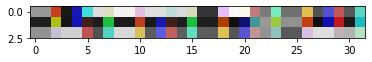

[1,     1] loss: 0.130
(512, 10)
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #               returns or see that `pin_memory_thread` died.


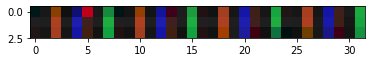

[1,     1] loss: 0.125
(512, 10)
sim (10, 10)
torch.float64


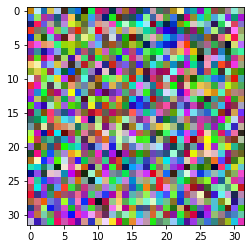

tensor([[ 0.3761, -0.3966,  0.1058,  0.6298,  0.5794,  0.3189, -0.1804,  0.1948,
         -0.2019, -0.6581]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


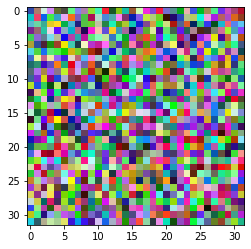

tensor([[ 0.3198, -0.3801,  0.1572,  0.8122,  0.6689,  0.4497, -0.2615,  0.2622,
         -0.1195, -0.7799]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #               returns or see that `pin_memory_thread` died.


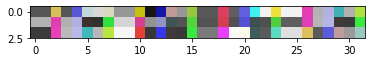

[1,     1] loss: 0.122
(512, 10)
sim (10, 10)
torch.float64


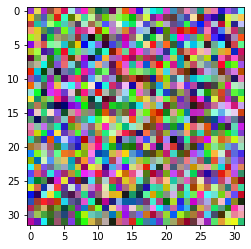

tensor([[ 0.2074, -0.5237,  0.2467,  0.7396,  0.6955,  0.3951, -0.0529,  0.2274,
         -0.3915, -0.7462]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


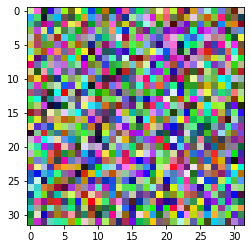

tensor([[ 0.3020, -0.4806,  0.1488,  0.7055,  0.6081,  0.4145, -0.1303,  0.1748,
         -0.3054, -0.7093]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


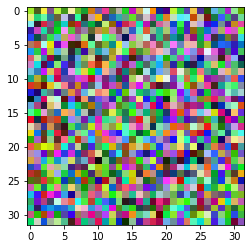

tensor([[ 0.2936, -0.5497,  0.1732,  0.7256,  0.7858,  0.4347, -0.1132,  0.3117,
         -0.4716, -0.7983]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


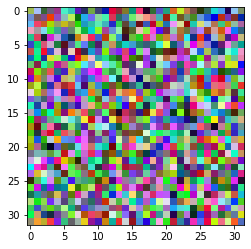

tensor([[ 0.3252, -0.4952,  0.0737,  0.6901,  0.5939,  0.3518, -0.1223,  0.1540,
         -0.2826, -0.6333]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #               returns or see that `pin_memory_thread` died.


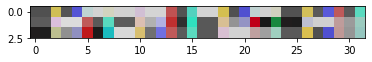

[1,     1] loss: 0.124
(512, 10)
sim (10, 10)
torch.float64


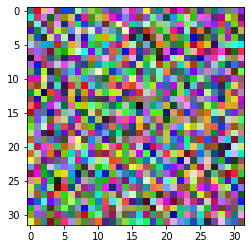

tensor([[ 0.1853, -0.5297,  0.1337,  0.8662,  0.6780,  0.4261, -0.0858,  0.1898,
         -0.4589, -0.7030]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


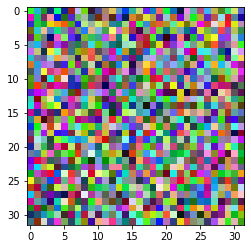

tensor([[ 0.2736, -0.4343,  0.0758,  0.7813,  0.6840,  0.3359, -0.1875,  0.2255,
         -0.2565, -0.7381]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


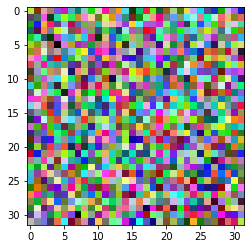

tensor([[ 0.2203, -0.2504, -0.0509,  0.7449,  0.7635,  0.2992, -0.2429,  0.1889,
         -0.3530, -0.5025]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


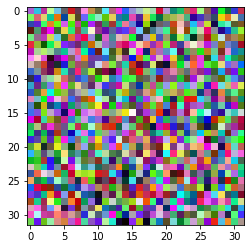

tensor([[ 0.3028, -0.3393,  0.1557,  0.7719,  0.6338,  0.4244, -0.2632,  0.2589,
         -0.1591, -0.7663]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


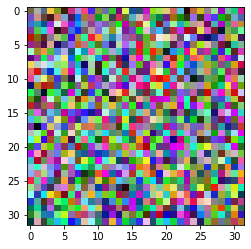

tensor([[ 0.2004, -0.5410,  0.1762,  0.7957,  0.6218,  0.5013, -0.1471,  0.1875,
         -0.2116, -0.7105]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


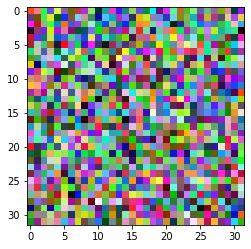

tensor([[ 0.2155, -0.2681,  0.1188,  0.7954,  0.6315,  0.3831, -0.2995,  0.1954,
         -0.0856, -0.7122]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #               returns or see that `pin_memory_thread` died.


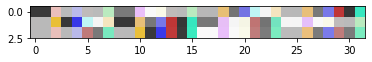

[1,     1] loss: 0.126
(512, 10)
sim (10, 10)
torch.float64


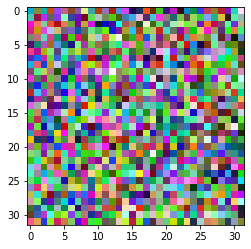

tensor([[ 0.3195, -0.4739,  0.1312,  0.8210,  0.6132,  0.4173, -0.1366,  0.1752,
         -0.1773, -0.7373]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


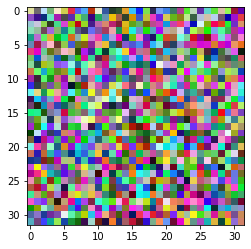

tensor([[ 0.2057, -0.4757,  0.1745,  0.8426,  0.6363,  0.3987, -0.0973,  0.2942,
         -0.4477, -0.6345]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


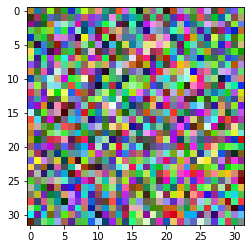

tensor([[ 0.3597, -0.4123,  0.0608,  0.6849,  0.6775,  0.3727, -0.2183,  0.1127,
         -0.1942, -0.6764]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


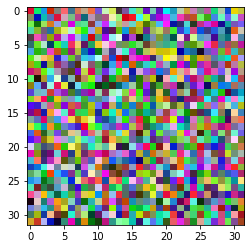

tensor([[ 0.2173, -0.4981,  0.1260,  0.8620,  0.6360,  0.4470, -0.0773,  0.2494,
         -0.2108, -0.7003]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


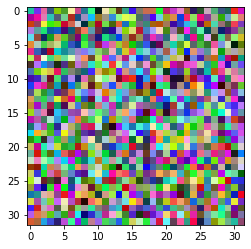

tensor([[ 0.2619, -0.5621,  0.1047,  0.6796,  0.6065,  0.4255,  0.0329,  0.2009,
         -0.2959, -0.7061]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


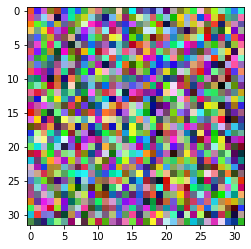

tensor([[ 0.2111, -0.5695,  0.1632,  0.7980,  0.7138,  0.3821, -0.0958,  0.2846,
         -0.3961, -0.7200]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


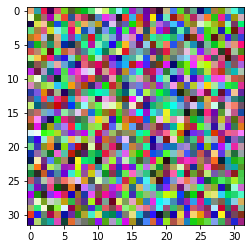

tensor([[ 0.3604, -0.3842,  0.0947,  0.8164,  0.6485,  0.4318, -0.1626,  0.1629,
         -0.2888, -0.7095]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
sim (10, 10)
torch.float64


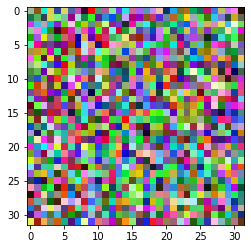

tensor([[ 0.3445, -0.5166,  0.2162,  0.6798,  0.5058,  0.4146, -0.1034,  0.2282,
         -0.2153, -0.7510]], dtype=torch.float32, grad_fn=<AddmmBackward0>)
Finished Training


In [ ]:
cif=SequentialCIFAR10(args)

import matplotlib.pyplot as plt
import numpy as np


from PIL import Image



lambda_coef=0.2 ### do sprawdzenia

for n_tasks in range(cif.N_TASKS):

  train_loader, test_loader=cif.get_data_loaders()

  for epoch in range(1):  # loop over the dataset multiple times


      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data



          ####### TODO - DISPLAY SAMPLES
          plt.imshow(transforms.ToPILImage()(inputs[0]))
          plt.show()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs.to(torch.float32))
          loss = criterion(outputs, labels)


          

          # print statistics
          running_loss += loss.item()
          if i % 20 == 0:    # print every 20 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
              running_loss = 0.0
              break

          if n_tasks>1:
              im1, log1 = model(synthetic_img)
              loss_mse=nn.optimizer.mse(log1, synthetic_logits)
              loss_total=loss+lambda_coeff*loss_mse

              loss_total.backward()
              optimizer.step()
              

  

  synthetic_img, synthetic_logits=recovery_memory(model,  cif, n_tasks)      ### or train_loader, param - ile wygenerować
 ######### zamienić n_tasks na listę klas już omówionych

print('Finished Training')

## Clone and checkout git repo

In [ ]:
!git clone https://github.com/agrudkow/Cost-Free-Incremental-Learning.git
%cd Cost-Free-Incremental-Learning
!git fetch --all

Cloning into 'Cost-Free-Incremental-Learning'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 103 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (103/103), 95.70 KiB | 1.99 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/Cost-Free-Incremental-Learning
Fetching origin


## Install requirements

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 104 kB 6.8 MB/s 
     |████████████████████████████████| 156 kB 36.0 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 2.7 MB 47.4 MB/s 
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 20.0 MB 1.6 MB/s 
     |████████████████████████████████| 146 kB 43.3 MB/s 
     |████████████████████████████████| 2.1 MB 30.8 MB/s 
     |████████████████████████████████| 1.3 MB 43.4 MB/s 
     |████████████████████████████████| 121 kB 44.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 57 kB 4.7 MB/s 
     |████████████████████████████████| 3.8 MB 32.5 MB/s 
     |████████████████████████████████| 734.6 MB 19 kB/s 
     |████████████████████████████████| 10.2 MB 24.6 MB/s 
     |████████████████████████████████| 127 kB 49.8 MB/s 
     |████

## Run model

In [ ]:
import os
import pathlib

os.environ['HOME_PATH'] = str(pathlib.Path().resolve())

In [ ]:
!python main.py \
  --model agem \
  --dataset seq-mnist \
  --buffer_size 5120 \
  --load_best_args

Namespace(batch_size=10, buffer_size=5120, csv_log=False, dataset='seq-mnist', load_best_args=True, lr=0.1, minibatch_size=128, model='agem', n_epochs=1, notes=None, seed=None, tensorboard=False, validation=False)
9920512it [00:00, 33479592.77it/s]                 
Extracting ./data/MNIST/MyMNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MyMNIST/raw
32768it [00:00, 882897.92it/s]
Extracting ./data/MNIST/MyMNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MyMNIST/raw
1654784it [00:00, 17992003.27it/s]
Extracting ./data/MNIST/MyMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MyMNIST/raw
8192it [00:00, 227234.92it/s]
Extracting ./data/MNIST/MyMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MyMNIST/raw
Processing...
Done!
9920512it [00:00, 37699114.06it/s]                 
Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw
32768it [00:00, 783788.91it/s]
Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

In [ ]:
/content/data/cifar-10-batches-py/data_batch_1/


[Errno 20] Not a directory: '/content/data/cifar-10-batches-py/data_batch_1/'
/content/Cost-Free-Incremental-Learning


In [ ]:
from datasets.utils.continual_dataset import ContinualDataset